# **XGBoost Modeling**

In [99]:
import pandas as pd
df = pd.read_csv('final_df.csv')
df.head()

,Year,Quarter,State,Pct_Telehealth,Real_GDP,Total_Population,Total_Male_Population%,Total_Female_Population%,Population_Under5%,Population5_17%,...,Black%,Hispanic%,Asian%,American_Indian_or_Alaska_Native%,Multiple_Races%,Region,pos,neu,neg,compound
0,2020,1,Alabama,0.0554,222288.8,4903185,0.483,0.517,0.058,0.163,...,0.265,0.044,0.014,0.004,0.019,South,0.0965,0.7927,0.1109,-0.01450
1,2020,1,Alaska,0.0758,50332.8,731545,0.520,0.480,0.070,0.176,...,0.022,0.070,0.060,0.151,0.083,West,0.0340,0.8955,0.0705,-0.18579
2,2020,1,Arizona,0.0617,365027.7,7278717,0.497,0.503,0.059,0.167,...,0.043,0.318,0.033,0.039,0.024,Southwest,0.0764,0.8259,0.0977,-0.16932
3,2020,1,Arkansas,0.0472,128340.9,3017804,0.489,0.511,0.061,0.171,...,0.152,0.078,0.016,0.006,0.024,South,0.0742,0.8370,0.0889,0.02960
4,2020,1,California,0.0915,2933320.2,39512223,0.497,0.503,0.060,0.165,...,0.053,0.395,0.147,0.004,0.033,West,0.1210,0.8126,0.0665,0.07139


In [100]:
df.shape

(816, 38)

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 816 entries, 0 to 815
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Year                               816 non-null    int64  
 1   Quarter                            816 non-null    int64  
 2   State                              816 non-null    object 
 3   Pct_Telehealth                     816 non-null    float64
 4   Real_GDP                           816 non-null    float64
 5   Total_Population                   816 non-null    int64  
 6   Total_Male_Population%             816 non-null    float64
 7   Total_Female_Population%           816 non-null    float64
 8   Population_Under5%                 816 non-null    float64
 9   Population5_17%                    816 non-null    float64
 10  Population18_24%                   816 non-null    float64
 11  Population25_34%                   816 non-null    float64

## **Correlation Matrix**

In [102]:
# examining if numeric variables are highly correlated with each other
numeric_df = df.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

correlation_matrix.style.background_gradient(cmap='coolwarm')

,Year,Quarter,Pct_Telehealth,Real_GDP,Total_Population,Total_Male_Population%,Total_Female_Population%,Population_Under5%,Population5_17%,Population18_24%,Population25_34%,Population35_44%,Population45_54%,Population55_64%,Population65_74%,Population_Over75%,Less_Than_High_School_Diploma%,High_School_Graduate%,Some_College_or_Associate Degree%,Bachelor_Degree%,Graduate_Or_Professional_Degree%,UnemploymentRate%,Private_Health_Insurance%,Public_Health_Insurance_Coverage%,No_Health_Insurance_Coverage%,Povery_Rate%,White%,Black%,Hispanic%,Asian%,American_Indian_or_Alaska_Native%,Multiple_Races%,pos,neu,neg,compound
Year,1.000000,0.000000,-0.489495,0.030950,0.006399,0.102174,-0.102174,-0.291600,-0.046868,-0.035540,-0.073349,0.293055,-0.191379,-0.205301,0.230486,0.215049,-0.160067,-0.090928,-0.074588,0.179293,0.121149,-0.263598,-0.024500,0.144738,-0.160838,-0.005858,-0.060580,-0.018898,0.036707,0.007571,-0.032613,0.292705,0.090306,-0.203237,0.176460,-0.085328
Quarter,0.000000,1.000000,-0.025054,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.015608,-0.075594,0.064349,-0.017735
Pct_Telehealth,-0.489495,-0.025054,1.000000,0.177373,0.151681,-0.183395,0.183395,-0.030902,-0.252479,-0.089305,0.221842,-0.072215,0.292485,0.165446,-0.144612,-0.037572,0.148451,-0.184314,-0.246778,0.101848,0.238989,0.273923,0.032274,0.031724,-0.131962,-0.129452,-0.216229,0.011701,0.199112,0.247065,-0.027917,-0.042089,-0.019486,0.117215,-0.139640,0.080781
Real_GDP,0.030950,0.000000,0.177373,1.000000,0.978847,-0.110181,0.110181,0.038578,0.017763,-0.100337,0.153156,0.144667,0.355211,-0.111052,-0.285409,-0.096670,0.504096,-0.278268,-0.240552,0.150065,0.095283,0.253702,-0.188241,-0.038336,0.131623,0.017073,-0.428019,0.075511,0.543303,0.284995,-0.233676,-0.117422,-0.042709,0.006660,0.015325,-0.086571
Total_Population,0.006399,0.000000,0.151681,0.978847,1.000000,-0.138664,0.138664,0.054841,0.050914,-0.117571,0.092480,0.086122,0.393032,-0.096986,-0.266004,-0.071125,0.536319,-0.200680,-0.200219,0.077062,0.018472,0.245112,-0.237599,-0.046230,0.230501,0.067444,-0.418159,0.113304,0.536563,0.230264,-0.252289,-0.151614,-0.058637,0.013537,0.016282,-0.094400
Total_Male_Population%,0.102174,-0.000000,-0.183395,-0.110181,-0.138664,1.000000,-1.000000,0.216632,0.440774,0.084251,-0.058775,0.149029,-0.425855,-0.234959,-0.043600,-0.243083,-0.387982,-0.023430,0.650858,0.109681,-0.413025,-0.292185,0.190044,-0.270241,0.166793,-0.357259,0.238975,-0.737902,0.052051,0.087326,0.554306,0.279569,0.045173,-0.052272,0.021961,0.038994
Total_Female_Population%,-0.102174,0.000000,0.183395,0.110181,0.138664,-1.000000,1.000000,-0.216632,-0.440774,-0.084251,0.058775,-0.149029,0.425855,0.234959,0.043600,0.243083,0.387982,0.023430,-0.650858,-0.109681,0.413025,0.292185,-0.190044,0.270241,-0.166793,0.357259,-0.238975,0.737902,-0.052051,-0.087326,-0.554306,-0.279569,-0.045173,0.052272,-0.021961,-0.038994
Population_Under5%,-0.291600,0.000000,-0.030902,0.038578,0.054841,0.216632,-0.216632,1.000000,0.758528,0.415786,0.305057,0.251987,-0.370112,-0.635147,-0.773305,-0.688634,0.179222,-0.037325,0.317356,-0.172722,-0.229383,-0.018861,0.068798,-0.483555,0.412401,0.128715,-0.160295,0.165312,0.016970,0.013189,0.254029,-0.048287,-0.052755,0.014614,0.014079,-0.020392
Population5_17%,-0.046868,0.000000,-0.252479,0.017763,0.050914,0.440774,-0.440774,0.758528,1.000000,0.389958,-0.154891,0.097811,-0.317952,-0.537301,-0.490709,-0.576514,0.172298,0.106098,0.611580,-0.268555,-0.555057,-0.124749,-0.074138,-0.384904,0.565565,0.117039,0.010338,-0.110179,0.109874,-0.128000,0.269696,-0.072686,-0.012353,-0.053464,0.064721,-0.042910
Population18_24%,-0.035540,0.000000,-0.089305,-0.100337,-0.117571,0.084251,-0.084251,0.415786,0.389958,1.000000,0.211621,0.079244,-0.421315,-0.462969,-0.508582,-0.436870,-0.03250

In [103]:
# drop Total_Population and Total_Female_Population% since they are highly correlated variables
df.drop(columns = ['Total_Population', 'Total_Female_Population%'], inplace = True)

In [104]:
# get dummies
df = pd.get_dummies(df, columns = ['State', 'Region'], drop_first = True).astype(float)

In [105]:
df2020 = df[df['Year'] == 2020]

df2021 = df[df['Year'] == 2021]

df2022 = df[df['Year'] == 2022]

df2023 = df[df['Year'] == 2023]

In [106]:
# dividing into testing and training data sets
from sklearn.model_selection import train_test_split
X2020 = df2020.drop(columns = ['Pct_Telehealth'])
y2020 = df2020['Pct_Telehealth']
X_train2020, X_test2020, y_train2020, y_test2020 = train_test_split(X2020, y2020, test_size=0.2, random_state=42)

X2021 = df2021.drop(columns = ['Pct_Telehealth'])
y2021 = df2021['Pct_Telehealth']
X_train2021, X_test2021, y_train2021, y_test2021 = train_test_split(X2021, y2021, test_size=0.2, random_state=42)

X2022 = df2022.drop(columns = ['Pct_Telehealth'])
y2022 = df2022['Pct_Telehealth']
X_train2022, X_test2022, y_train2022, y_test2022 = train_test_split(X2022, y2022, test_size=0.2, random_state=42)

X2023 = df2023.drop(columns = ['Pct_Telehealth'])
y2023 = df2023['Pct_Telehealth']
X_train2023, X_test2023, y_train2023, y_test2023 = train_test_split(X2023, y2023, test_size=0.2, random_state=42)

## **XGBoost Models**

### XGBoost Model for 2020

In [155]:
## Step 1: Creating the Model

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# including regularization terms since the model has many predictors and faces some multicollinearity issues
param_grid = {
    "learning_rate" : [0.001, 0.01, 0.05],
    "max_depth" : [3, 4, 5],
    "n_estimators" : [50, 75, 100],
    'reg_alpha': [0, 0.01, 0.1], # default 0
    'reg_lambda': [2, 3, 4] # default 1
}

xgb = XGBRegressor()

grid_search_xgb2020 = GridSearchCV(estimator = xgb, param_grid = param_grid, cv = 5, n_jobs = -1)
grid_search_xgb2020.fit(X_train2020, y_train2020)

print(grid_search_xgb2020.best_params_)

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.01, 'reg_lambda': 2}


In [162]:
## Step 2: Calculating Performance Metrics

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predict on the next year test set using the best estimator
y_pred2021 = grid_search_xgb2020.best_estimator_.predict(X_test2021)

# Calculate R-squared
r2 = r2_score(y_test2021, y_pred2021)
# r2 = r2_score(y_test2021, y_pred2021)
print(f"R-squared: {r2}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test2021, y_pred2021))
print(f"RMSE: {rmse}")

R-squared: -8.380672935458122
RMSE: 0.195612763934274


## for the above, should we compare against the y_test for 2020 or for 2021? when i did this, I got a negative R squared value...

In [109]:
## Step 3: Creating the Best Model with Given Hyperparameters
xgb2020 = XGBRegressor(learning_rate= 0.05, max_depth= 3, n_estimators= 100,
                   reg_alpha= 0.01, reg_lambda= 2)

xgb2020.fit(X_train2020, y_train2020)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.15, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=125, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [110]:
## Step 4: Feature Importances
importances = xgb2020.get_booster().get_score(importance_type='gain')

# Map feature importances to feature names (sorted)
feature_importances = pd.DataFrame({'Feature': list(importances.keys()), 'Importance': list(importances.values())})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

feature_importances.head(10)

# Use "gain" if you want to focus on the most important features in terms
# of improving predictive performance and model accuracy.

,Feature,Importance
0,Quarter,0.082667
41,Region_Northeast,0.071933
25,Asian%,0.057140
16,Graduate_Or_Professional_Degree%,0.034146
22,White%,0.022619
14,Some_College_or_Associate Degree%,0.016822
17,UnemploymentRate%,0.010508
20,No_Health_Insurance_Coverage%,0.008044
18,Private_Health_Insurance%,0.006772
19,Public_Health_Insurance_Coverage%,0.004912


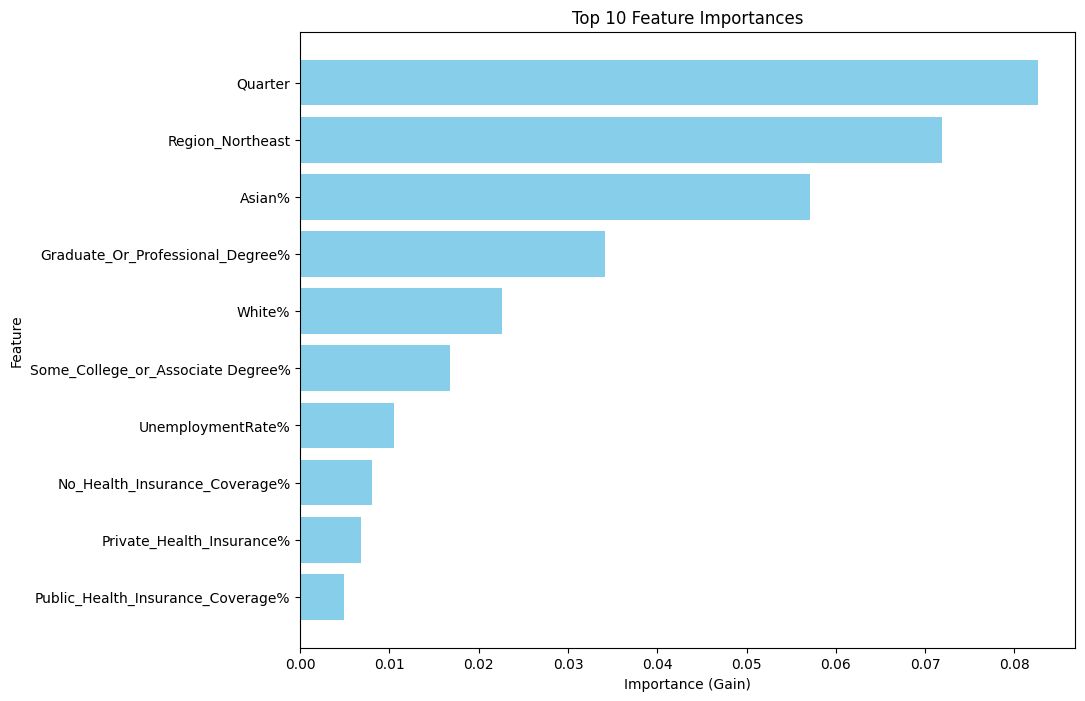

In [111]:
# visualize the feature importances as a bar chart
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Get feature importances (using 'gain' as the importance type)
importances = xgb2020.get_booster().get_score(importance_type='gain')

# Sort the features by importance (in descending order)
sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

# Select the top 10 features
top_10_features = dict(sorted_importances[:10])

# Convert the top 10 features into a pandas DataFrame for easy plotting
top_10_df = pd.DataFrame(list(top_10_features.items()), columns=['Feature', 'Importance'])

# Plot the top 10 features using a horizontal bar plot
plt.figure(figsize=(10, 8))
plt.barh(top_10_df['Feature'], top_10_df['Importance'], color='skyblue')
plt.xlabel('Importance (Gain)')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()


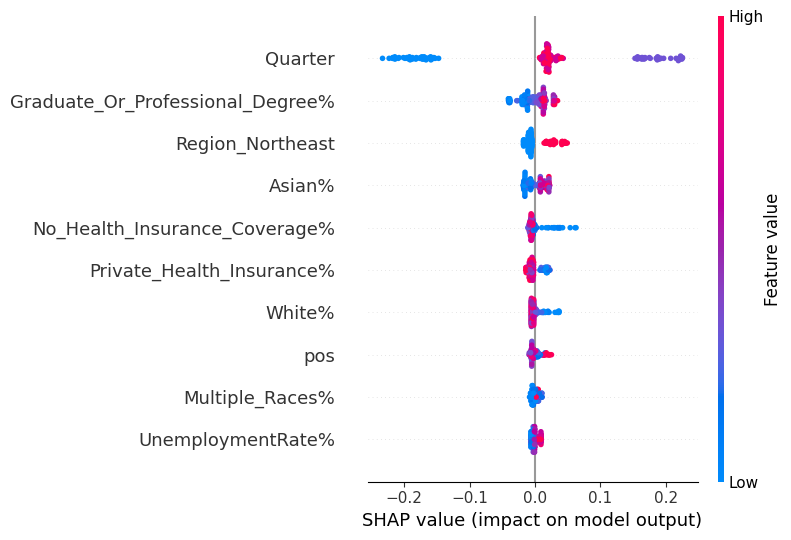

In [112]:
## Step 5: Examining the influence of significant variables on percent_telehealth
import shap

# Create the SHAP explainer
explainer = shap.Explainer(xgb2020)  # xgb2020 is your trained XGBRegressor model

# Get SHAP values for the training data (or test data)
shap_values = explainer(X_train2020)

shap.summary_plot(shap_values, X_train2020, max_display=10)

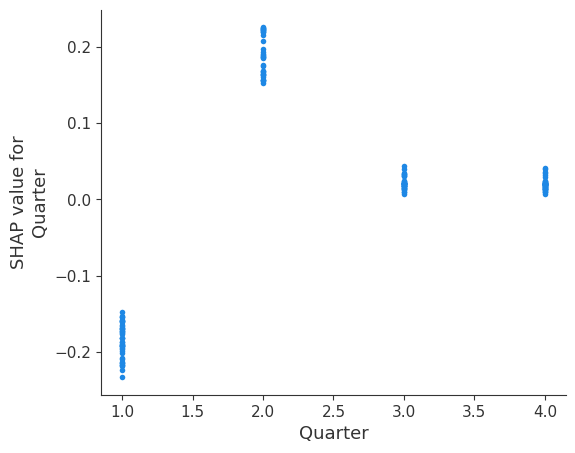

In [113]:
import shap
import matplotlib.pyplot as plt

# Get SHAP values for the training data (assuming xgb2020 is your trained model)
explainer = shap.Explainer(xgb2020)  # Replace xgb2020 with your trained model
shap_values = explainer(X_train2020)  # Replace with your data (X_train2020 or X_test2020)

# Plot the dependence plot for a specific feature (e.g., 'Quarter')
shap.dependence_plot('Quarter', shap_values.values, X_train2020, interaction_index=None)

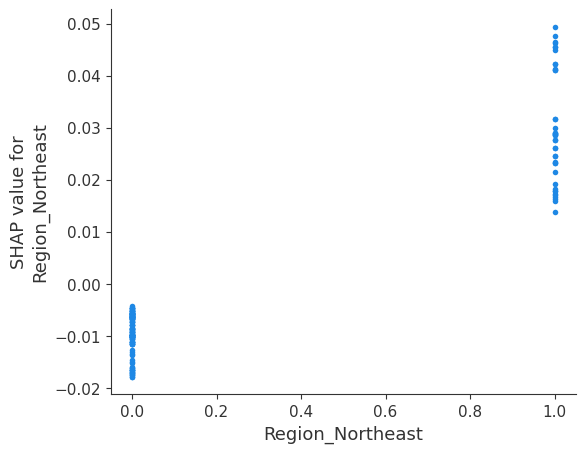

In [114]:
shap.dependence_plot('Region_Northeast', shap_values.values, X_train2020, interaction_index=None)

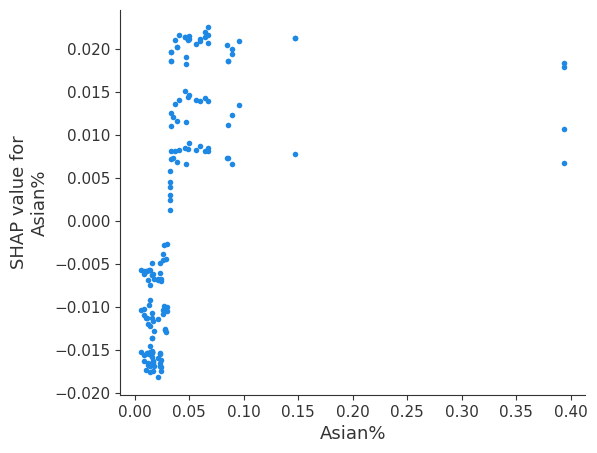

In [116]:
shap.dependence_plot('Asian%', shap_values.values, X_train2020, interaction_index=None)

### XGBoost Model for 2021

In [157]:
## Step 1: Creating the Model

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# including regularization terms since the model has many predictors and faces some multicollinearity issues
param_grid = {
    "learning_rate" : [0.001, 0.01, 0.05],
    "max_depth" : [3, 4, 5],
    "n_estimators" : [50, 75, 100],
    'reg_alpha': [0, 0.01, 0.1], # default 0
    'reg_lambda': [1, 2, 3] # default 1
}

xgb = XGBRegressor()

grid_search_xgb2021 = GridSearchCV(estimator = xgb, param_grid = param_grid, cv = 5, n_jobs = -1)
grid_search_xgb2021.fit(X_train2021, y_train2021)

print(grid_search_xgb2021.best_params_)

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.01, 'reg_lambda': 1}


In [163]:
## Step 2: Calculating Performance Metrics

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predict on the next year test set using the best estimator
y_pred2022 = grid_search_xgb2021.best_estimator_.predict(X_test2022)

# Calculate R-squared
r2 = r2_score(y_test2022, y_pred2022)
print(f"R-squared: {r2}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test2022, y_pred2022))
print(f"RMSE: {rmse}")

R-squared: 0.3183327724077365
RMSE: 0.04229330640816855


In [119]:
## Step 3: Creating the Best Model with Given Hyperparameters
xgb2021 = XGBRegressor(learning_rate= 0.3, max_depth= 3, n_estimators= 75,
                   reg_alpha= 0, reg_lambda= 1)

xgb2021.fit(X_train2021, y_train2021)

## Step 4: Feature Importances
importances = xgb2021.get_booster().get_score(importance_type='gain')

# Map feature importances to feature names (sorted)
feature_importances = pd.DataFrame({'Feature': list(importances.keys()), 'Importance': list(importances.values())})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

feature_importances.head(10)

# Use "gain" if you want to focus on the most important features in terms
# of improving predictive performance and model accuracy.

,Feature,Importance
16,Graduate_Or_Professional_Degree%,0.045788
24,Hispanic%,0.042449
17,UnemploymentRate%,0.025026
25,Asian%,0.015763
0,Quarter,0.015500
20,No_Health_Insurance_Coverage%,0.014495
14,Some_College_or_Associate Degree%,0.010783
42,Region_South,0.010035
26,American_Indian_or_Alaska_Native%,0.006286
13,High_School_Graduate%,0.004787


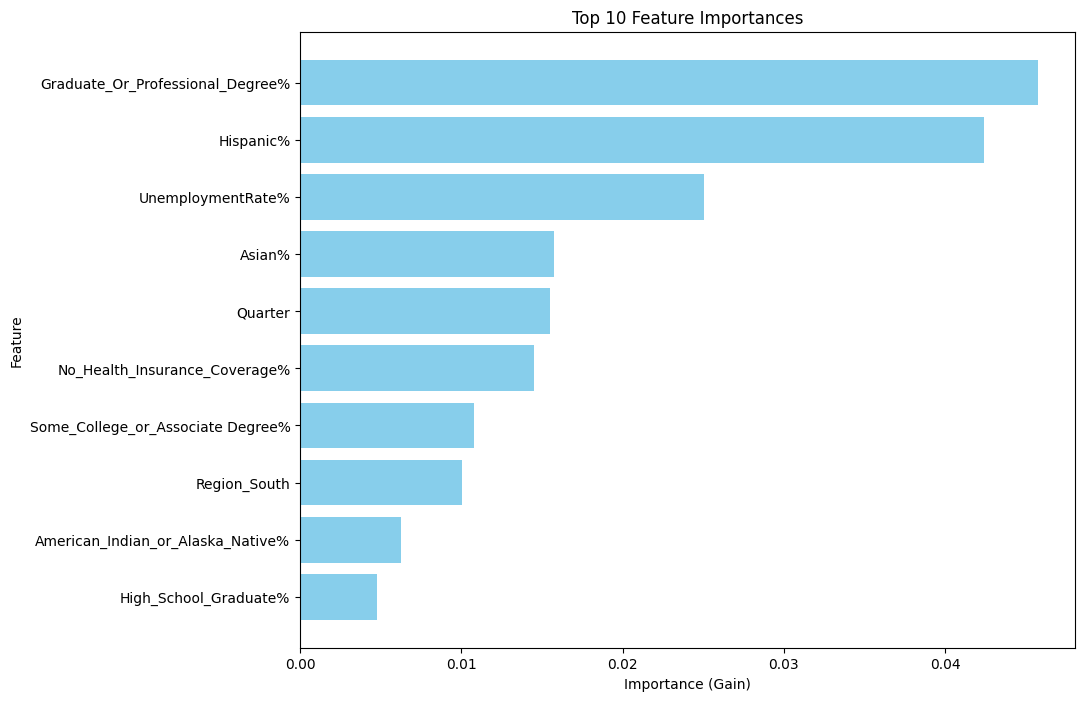

In [120]:
# visualize the feature importances as a bar chart
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Get feature importances (using 'gain' as the importance type)
importances = xgb2021.get_booster().get_score(importance_type='gain')

# Sort the features by importance (in descending order)
sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

# Select the top 10 features
top_10_features = dict(sorted_importances[:10])

# Convert the top 10 features into a pandas DataFrame for easy plotting
top_10_df = pd.DataFrame(list(top_10_features.items()), columns=['Feature', 'Importance'])

# Plot the top 10 features using a horizontal bar plot
plt.figure(figsize=(10, 8))
plt.barh(top_10_df['Feature'], top_10_df['Importance'], color='skyblue')
plt.xlabel('Importance (Gain)')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

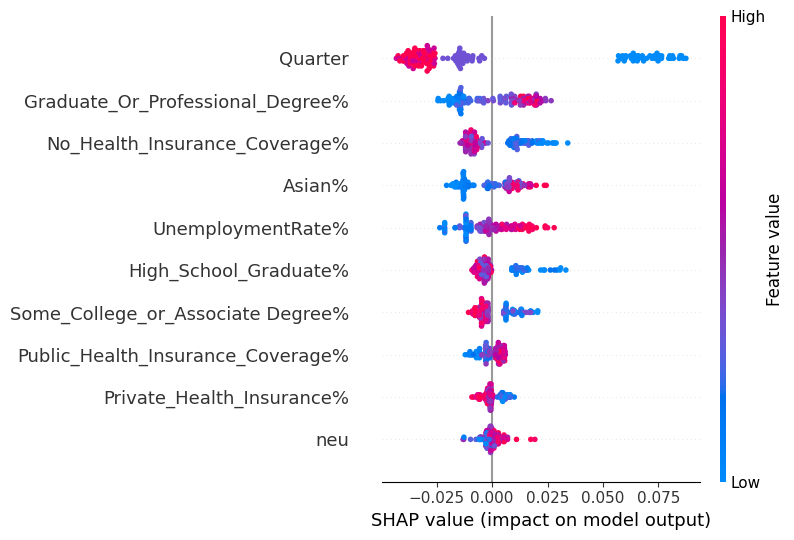

In [121]:
## Step 5: Examining the influence of significant variables on percent_telehealth
import shap

# Create the SHAP explainer
explainer = shap.Explainer(xgb2021)

# Get SHAP values for the training data (or test data)
shap_values = explainer(X_train2021)  # Replace with X_test2020 for test data

shap.summary_plot(shap_values, X_train2021, max_display=10)

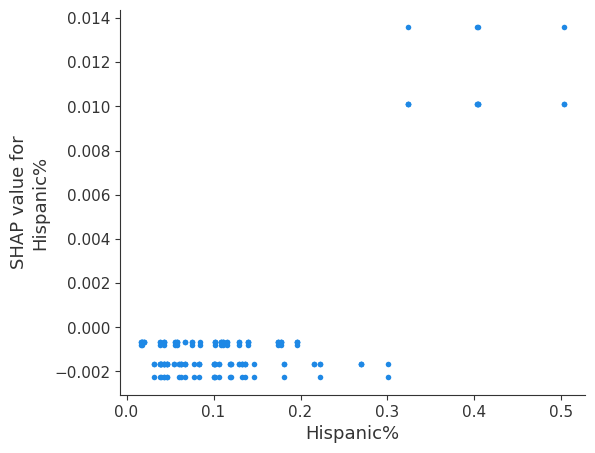

In [123]:
import shap
import matplotlib.pyplot as plt

# Get SHAP values for the training data (assuming xgb2020 is your trained model)
explainer = shap.Explainer(xgb2021)
shap_values = explainer(X_train2021)

# Plot the dependence plot for a specific feature (e.g., 'Quarter')
shap.dependence_plot('Hispanic%', shap_values.values, X_train2021, interaction_index=None)

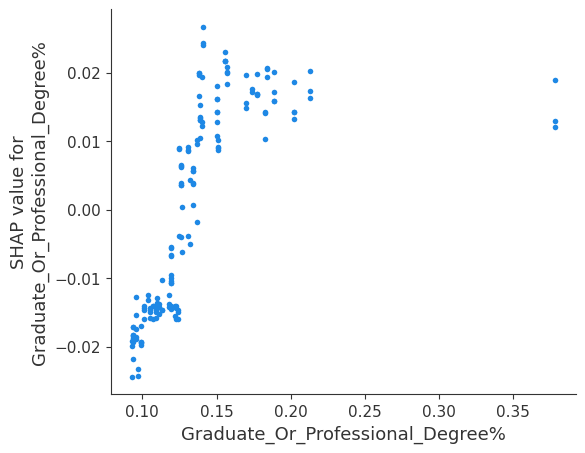

In [124]:
# Plot the dependence plot for a specific feature (e.g., 'Quarter')
shap.dependence_plot('Graduate_Or_Professional_Degree%', shap_values.values, X_train2021, interaction_index=None)

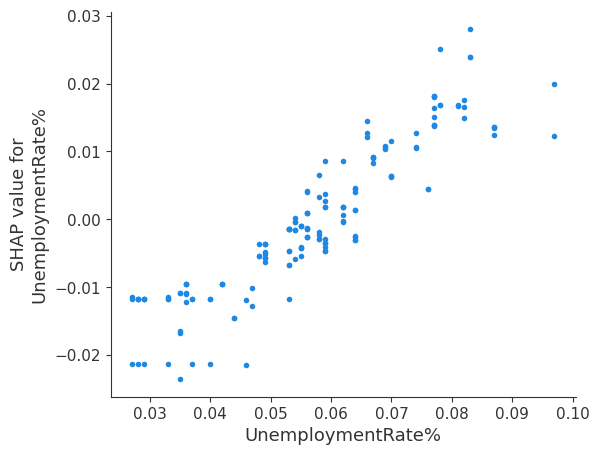

In [125]:
# Plot the dependence plot for a specific feature (e.g., 'Quarter')
shap.dependence_plot('UnemploymentRate%', shap_values.values, X_train2021, interaction_index=None)

### XGBoost Model for 2022

In [159]:
## Step 1: Creating the Model

## reduce overfitting when re-running this 2022 model and 2023 model

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# including regularization terms since the model has many predictors and faces some multicollinearity issues
param_grid = {
    "learning_rate" : [0.001, 0.01, 0.05],
    "max_depth" : [3, 4, 5],
    "n_estimators" : [50, 75, 100],
    'reg_alpha': [0, 0.01, 0.1], # default 0
    'reg_lambda': [1, 2, 3] # default 1
}

xgb = XGBRegressor()

grid_search_xgb2022 = GridSearchCV(estimator = xgb, param_grid = param_grid, cv = 5, n_jobs = -1)
grid_search_xgb2022.fit(X_train2022, y_train2022)

print(grid_search_xgb2022.best_params_)

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1}


In [164]:
## Step 2: Calculating Performance Metrics

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predict on the next year test set using the best estimator
y_pred2023 = grid_search_xgb2022.best_estimator_.predict(X_test2023)

# Calculate R-squared
r2 = r2_score(y_test2023, y_pred2023)
print(f"R-squared: {r2}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test2023, y_pred2023))
print(f"RMSE: {rmse}")

R-squared: 0.1658287034661552
RMSE: 0.0383250904832574


In [161]:
## Step 3: Creating the Best Model with Given Hyperparameters
xgb2022 = XGBRegressor(learning_rate= 0.2, max_depth= 3, n_estimators= 125,
                   reg_alpha= 0, reg_lambda= 4)

xgb2022.fit(X_train2022, y_train2022)

## Step 4: Feature Importances
importances = xgb2022.get_booster().get_score(importance_type='gain')

# Map feature importances to feature names (sorted)
feature_importances = pd.DataFrame({'Feature': list(importances.keys()), 'Importance': list(importances.values())})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

feature_importances.head(10)

# Use "gain" if you want to focus on the most important features in terms
# of improving predictive performance and model accuracy.

,Feature,Importance
25,Asian%,0.036570
39,Region_South,0.007732
3,Population_Under5%,0.007360
22,White%,0.006323
38,Region_Northeast,0.004707
4,Population5_17%,0.004349
9,Population55_64%,0.002761
27,Multiple_Races%,0.002740
24,Hispanic%,0.002061
13,High_School_Graduate%,0.001996


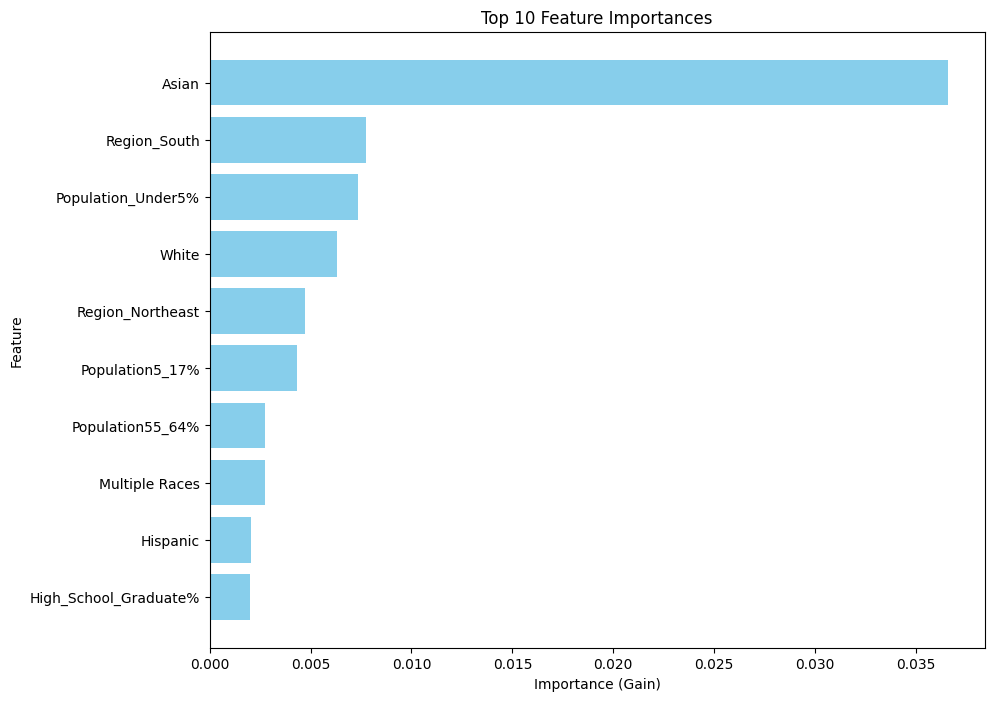

In [84]:
# visualize the feature importances as a bar chart
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Get feature importances (using 'gain' as the importance type)
importances = xgb2022.get_booster().get_score(importance_type='gain')

# Sort the features by importance (in descending order)
sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

# Select the top 10 features
top_10_features = dict(sorted_importances[:10])

# Convert the top 10 features into a pandas DataFrame for easy plotting
top_10_df = pd.DataFrame(list(top_10_features.items()), columns=['Feature', 'Importance'])

# Plot the top 10 features using a horizontal bar plot
plt.figure(figsize=(10, 8))
plt.barh(top_10_df['Feature'], top_10_df['Importance'], color='skyblue')
plt.xlabel('Importance (Gain)')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

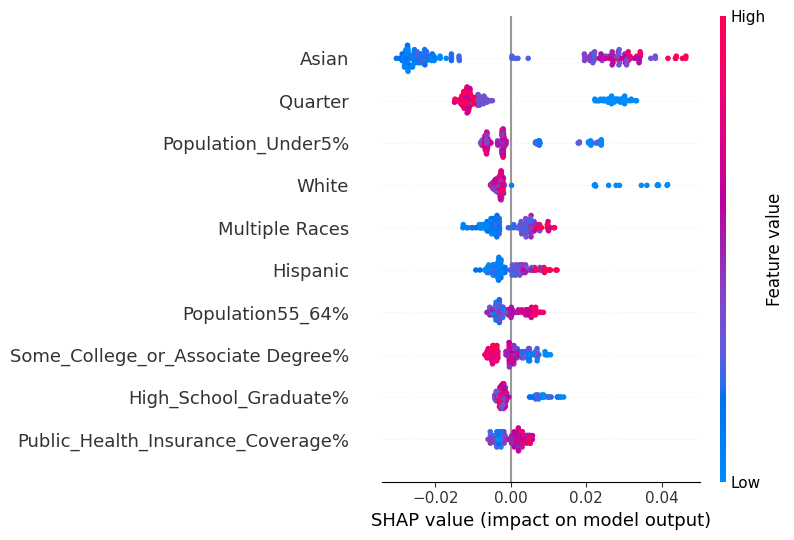

In [85]:
## Step 5: Examining the influence of significant variables on percent_telehealth
import shap

# Create the SHAP explainer
explainer = shap.Explainer(xgb2022)

# Get SHAP values for the training data (or test data)
shap_values = explainer(X_train2022)

shap.summary_plot(shap_values, X_train2022, max_display=10)

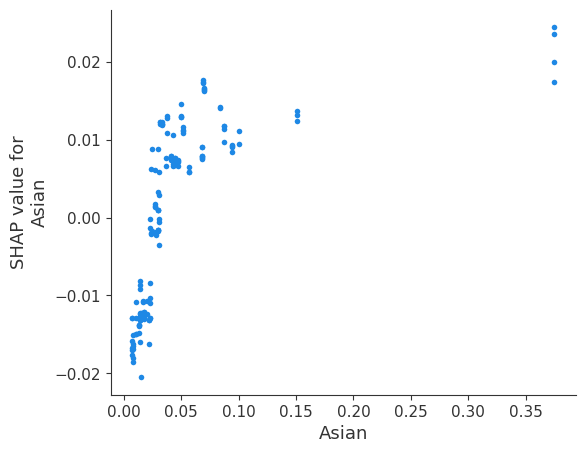

In [86]:
import shap
import matplotlib.pyplot as plt

# Get SHAP values for the training data (assuming xgb2020 is your trained model)
explainer = shap.Explainer(xgb2022)
shap_values = explainer(X_train2022)

# Plot the dependence plot for a specific feature (e.g., 'Quarter')
shap.dependence_plot('Asian', shap_values.values, X_train2022, interaction_index=None)

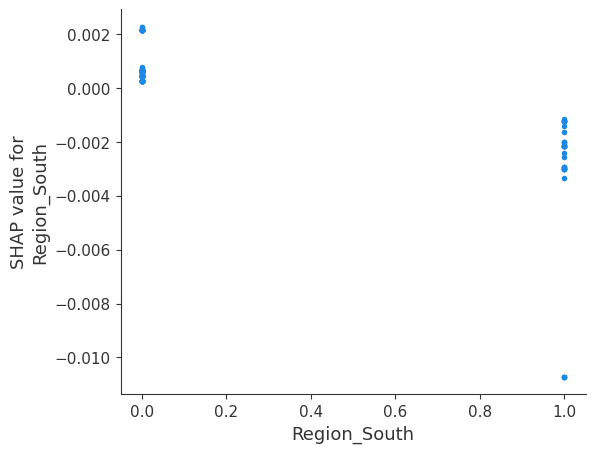

In [87]:
# Plot the dependence plot for a specific feature (e.g., 'Quarter')
shap.dependence_plot('Region_South', shap_values.values, X_train2022, interaction_index=None)

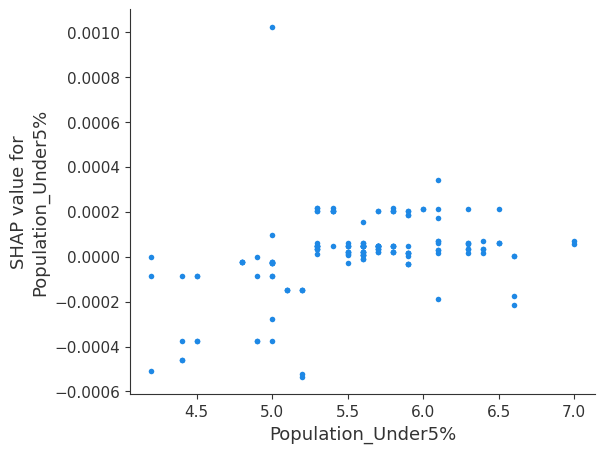

In [88]:
# Plot the dependence plot for a specific feature (e.g., 'Quarter')
shap.dependence_plot('Population_Under5%', shap_values.values, X_train2022, interaction_index=None)

### XGBoost Model for 2023

In [126]:
## Step 1: Creating the Model

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# including regularization terms since the model has many predictors and faces some multicollinearity issues
param_grid = {
    "learning_rate" : [0.2, 0.3, 0.4],
    "max_depth" : [3, 5, 7],
    "n_estimators" : [50, 75, 100],
    'reg_alpha': [0, 0.01, 0.1], # default 0
    'reg_lambda': [1, 2, 3] # default 1
}

xgb = XGBRegressor()

grid_search_xgb2023 = GridSearchCV(estimator = xgb, param_grid = param_grid, cv = 5, n_jobs = -1)
grid_search_xgb2023.fit(X_train2023, y_train2023)

print(grid_search_xgb2023.best_params_)

{'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 75, 'reg_alpha': 0, 'reg_lambda': 1}


In [165]:
## Step 2: Calculating Performance Metrics

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predict on the next year test set using the best estimator
y_pred2024 = grid_search_xgb2023.best_estimator_.predict(X_test2023)

# Calculate R-squared
r2 = r2_score(y_test2023, y_pred2024)
print(f"R-squared: {r2}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test2023, y_pred2024))
print(f"RMSE: {rmse}")

R-squared: 0.9829701929973023
RMSE: 0.00547596206673111


In [128]:
## Step 3: Creating the Best Model with Given Hyperparameters
xgb2023 = XGBRegressor(learning_rate= 0.3, max_depth= 3, n_estimators= 75,
                   reg_alpha= 0, reg_lambda= 1)

xgb2023.fit(X_train2023, y_train2023)

## Step 4: Feature Importances
importances = xgb2023.get_booster().get_score(importance_type='gain')

# Map feature importances to feature names (sorted)
feature_importances = pd.DataFrame({'Feature': list(importances.keys()), 'Importance': list(importances.values())})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

feature_importances.head(10)

# Use "gain" if you want to focus on the most important features in terms
# of improving predictive performance and model accuracy.

,Feature,Importance
25,Asian%,0.029574
11,Population_Over75%,0.014258
39,Region_South,0.011872
22,White%,0.007374
17,UnemploymentRate%,0.003325
16,Graduate_Or_Professional_Degree%,0.003108
14,Some_College_or_Associate Degree%,0.002905
20,No_Health_Insurance_Coverage%,0.001981
6,Population25_34%,0.001293
19,Public_Health_Insurance_Coverage%,0.001073


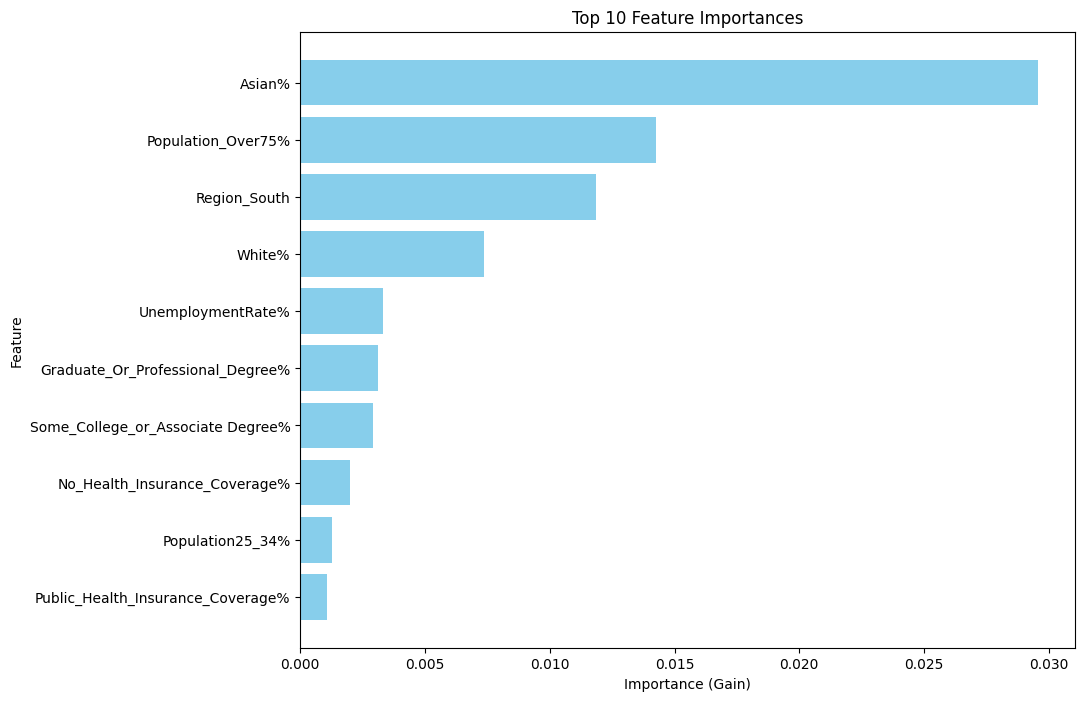

In [129]:
# visualize the feature importances as a bar chart
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Get feature importances (using 'gain' as the importance type)
importances = xgb2023.get_booster().get_score(importance_type='gain')

# Sort the features by importance (in descending order)
sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

# Select the top 10 features
top_10_features = dict(sorted_importances[:10])

# Convert the top 10 features into a pandas DataFrame for easy plotting
top_10_df = pd.DataFrame(list(top_10_features.items()), columns=['Feature', 'Importance'])

# Plot the top 10 features using a horizontal bar plot
plt.figure(figsize=(10, 8))
plt.barh(top_10_df['Feature'], top_10_df['Importance'], color='skyblue')
plt.xlabel('Importance (Gain)')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

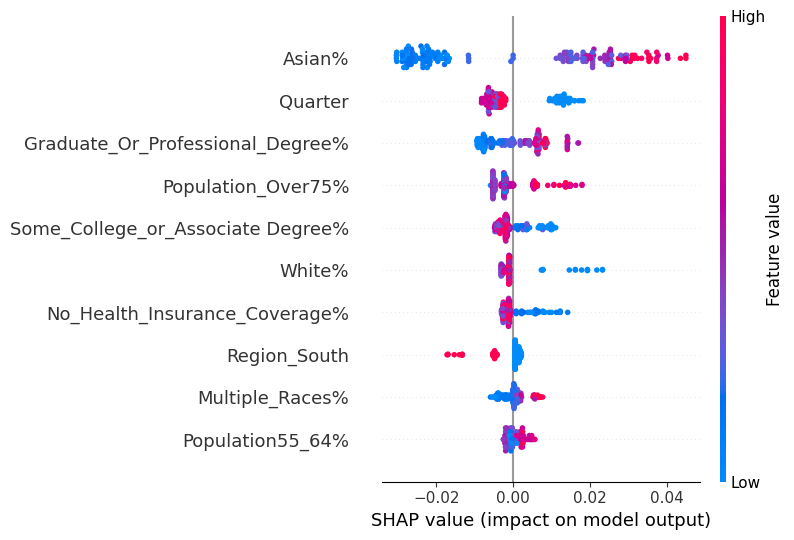

In [130]:
## Step 5: Examining the influence of significant variables on percent_telehealth
import shap

# Create the SHAP explainer
explainer = shap.Explainer(xgb2023)

# Get SHAP values for the training data (or test data)
shap_values = explainer(X_train2023)

shap.summary_plot(shap_values, X_train2023, max_display=10)

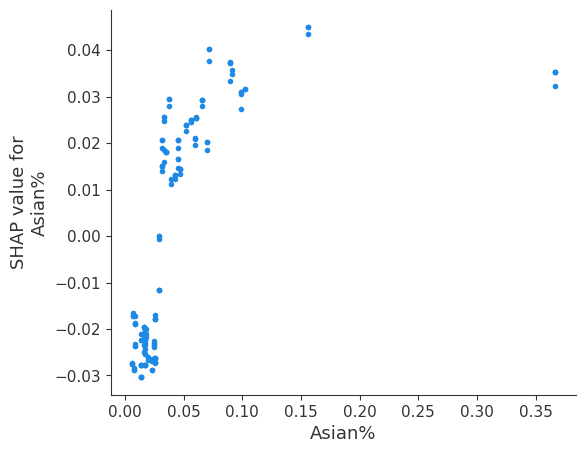

In [132]:
import shap
import matplotlib.pyplot as plt

# Get SHAP values for the training data (assuming xgb2020 is your trained model)
explainer = shap.Explainer(xgb2023)
shap_values = explainer(X_train2023)

# Plot the dependence plot for a specific feature (e.g., 'Quarter')
shap.dependence_plot('Asian%', shap_values.values, X_train2023, interaction_index=None)

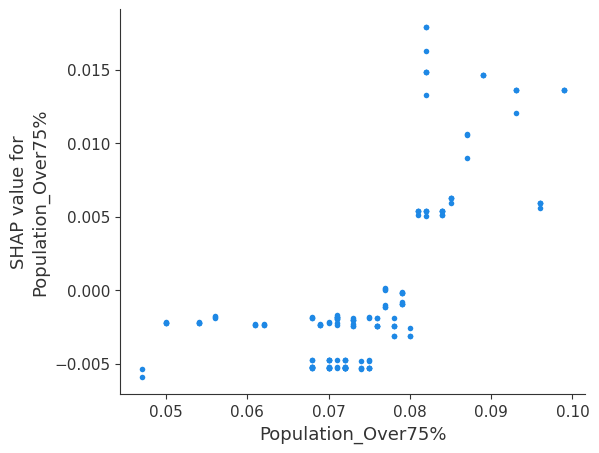

In [133]:
# Plot the dependence plot for a specific feature (e.g., 'Quarter')
shap.dependence_plot('Population_Over75%', shap_values.values, X_train2023, interaction_index=None)

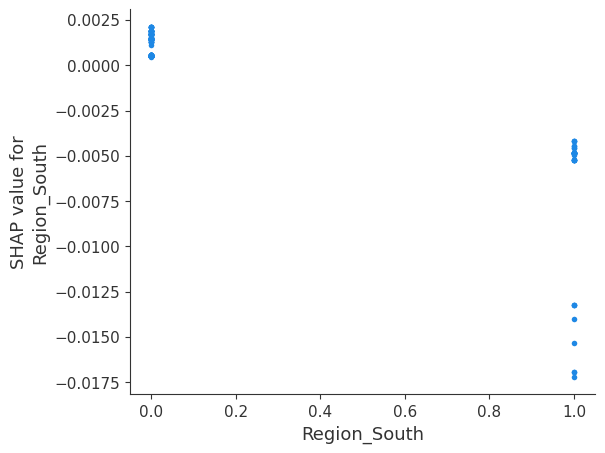

In [134]:
# Plot the dependence plot for a specific feature (e.g., 'Quarter')
shap.dependence_plot('Region_South', shap_values.values, X_train2023, interaction_index=None)

#### **Examining the Impact of Sentiment Analysis**

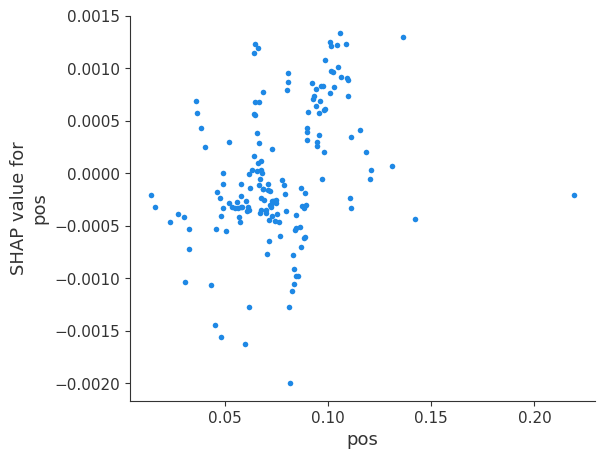

In [135]:
# Plot the dependence plot for a specific feature (e.g., 'Quarter')
shap.dependence_plot('pos', shap_values.values, X_train2023, interaction_index=None)

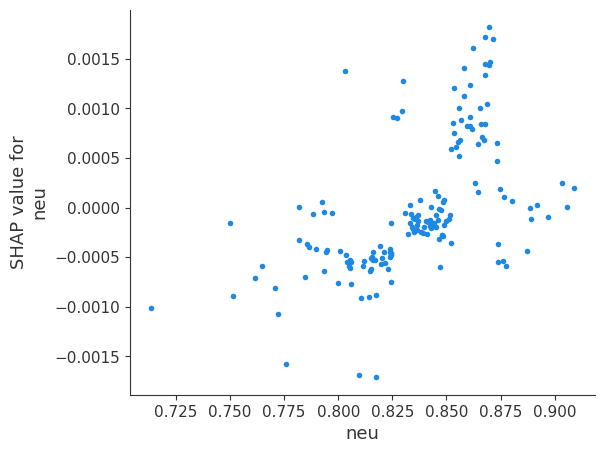

In [136]:
# Plot the dependence plot for a specific feature (e.g., 'Quarter')
shap.dependence_plot('neu', shap_values.values, X_train2023, interaction_index=None)

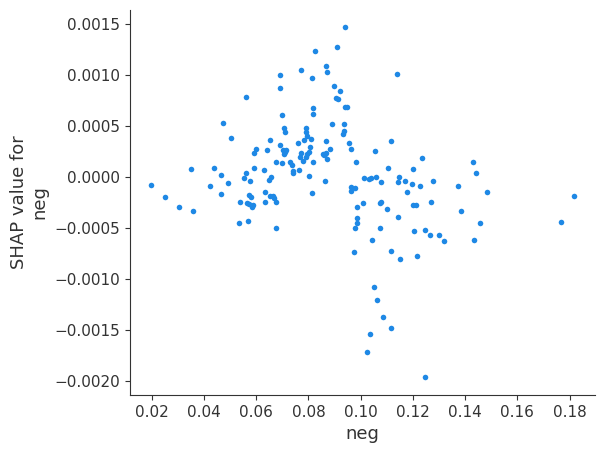

In [137]:
# Plot the dependence plot for a specific feature (e.g., 'Quarter')
shap.dependence_plot('neg', shap_values.values, X_train2023, interaction_index=None)

## **Combining Predictions for 2021 to 2024**

In [172]:
# 2021 predictions
predictions2021 = pd.concat([X_test2021, pd.DataFrame(y_pred2021, index=X_test2021.index)], axis = 1)

# Rename the last column to 'predictions'
predictions2021.columns = list(X_test2021.columns) + ['Pct_Telehealth_Predictions']

predictions2021.head()

,Year,Quarter,Real_GDP,Total_Male_Population%,Population_Under5%,Population5_17%,Population18_24%,Population25_34%,Population35_44%,Population45_54%,...,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming,Region_Northeast,Region_South,Region_Southwest,Region_West,Pct_Telehealth_Predictions
219,2021.0,1.0,201147.1,0.502,0.059,0.172,0.100,0.122,0.128,0.111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.075909
213,2021.0,1.0,1170526.3,0.492,0.050,0.147,0.079,0.126,0.125,0.125,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.084690
319,2021.0,3.0,855888.1,0.494,0.056,0.165,0.090,0.135,0.133,0.125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.294534
282,2021.0,2.0,134939.9,0.502,0.063,0.182,0.096,0.129,0.132,0.110,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.349417
270,2021.0,2.0,201147.1,0.502,0.059,0.172,0.100,0.122,0.128,0.111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.352559


In [173]:
# 2022 predictions
predictions2022 = pd.concat([X_test2022, pd.DataFrame(y_pred2022, index=X_test2022.index)], axis = 1)

# Rename the last column to 'predictions'
predictions2022.columns = list(X_test2022.columns) + ['Pct_Telehealth_Predictions']

predictions2022.head()

,Year,Quarter,Real_GDP,Total_Male_Population%,Population_Under5%,Population5_17%,Population18_24%,Population25_34%,Population35_44%,Population45_54%,...,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming,Region_Northeast,Region_South,Region_Southwest,Region_West,Pct_Telehealth_Predictions
423,2022.0,1.0,201580.4,0.502,0.056,0.168,0.101,0.126,0.127,0.113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.212417
417,2022.0,1.0,1239883.6,0.492,0.050,0.144,0.083,0.125,0.126,0.123,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.231096
523,2022.0,3.0,876536.0,0.495,0.054,0.162,0.093,0.134,0.133,0.124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.147219
486,2022.0,2.0,139440.9,0.502,0.062,0.180,0.098,0.128,0.134,0.110,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.104762
474,2022.0,2.0,201580.4,0.502,0.056,0.168,0.101,0.126,0.127,0.113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.124083


In [174]:
# 2023 predictions
predictions2023 = pd.concat([X_test2023, pd.DataFrame(y_pred2023, index=X_test2023.index)], axis = 1)

# Rename the last column to 'predictions'
predictions2023.columns = list(X_test2023.columns) + ['Pct_Telehealth_Predictions']

predictions2023.head()

,Year,Quarter,Real_GDP,Total_Male_Population%,Population_Under5%,Population5_17%,Population18_24%,Population25_34%,Population35_44%,Population45_54%,...,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming,Region_Northeast,Region_South,Region_Southwest,Region_West,Pct_Telehealth_Predictions
627,2023.0,1.0,202051.4,0.500,0.057,0.169,0.098,0.124,0.128,0.114,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.120021
621,2023.0,1.0,1292787.6,0.492,0.050,0.144,0.080,0.124,0.128,0.122,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.182612
727,2023.0,3.0,885651.3,0.494,0.053,0.163,0.091,0.134,0.134,0.124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.156816
690,2023.0,2.0,145019.6,0.502,0.061,0.181,0.097,0.128,0.132,0.111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090917
678,2023.0,2.0,202051.4,0.500,0.057,0.169,0.098,0.124,0.128,0.114,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.082200


### **when appending together predictions, do we manually change the 'Year' values from 2023 to 2024 since they represent next years predictions, using 2023's data?**

In [178]:
# 2024 predictions were calculated from X_test
predictions2024 = pd.concat([X_test2023, pd.DataFrame(y_pred2024, index=X_test2023.index)], axis = 1)

# Rename the last column to 'predictions'
predictions2024.columns = list(X_test2023.columns) + ['Pct_Telehealth_Predictions']

# change the year column from 2023 values to 2024 values
predictions2024['Year'] = 2024.0

predictions2024.head()

,Year,Quarter,Real_GDP,Total_Male_Population%,Population_Under5%,Population5_17%,Population18_24%,Population25_34%,Population35_44%,Population45_54%,...,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming,Region_Northeast,Region_South,Region_Southwest,Region_West,Pct_Telehealth_Predictions
627,2024.0,1.0,202051.4,0.500,0.057,0.169,0.098,0.124,0.128,0.114,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069548
621,2024.0,1.0,1292787.6,0.492,0.050,0.144,0.080,0.124,0.128,0.122,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.139014
727,2024.0,3.0,885651.3,0.494,0.053,0.163,0.091,0.134,0.134,0.124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.108667
690,2024.0,2.0,145019.6,0.502,0.061,0.181,0.097,0.128,0.132,0.111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.061939
678,2024.0,2.0,202051.4,0.500,0.057,0.169,0.098,0.124,0.128,0.114,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055622


In [180]:
predictions2021.shape

(41, 88)

In [181]:
## appending all prediction dataframes into one data set by rows
all_predictions = pd.concat([predictions2021, predictions2022, predictions2023, predictions2024], axis = 0)

all_predictions.shape

(164, 88)